In [113]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display

import duckdb
import pandas as pd
from pathlib import Path
import logging
from Bio import SeqIO
from datetime import datetime
import time

from typing import List, Optional, Union, Dict, Set

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
SAMPLES = ['SRR12068547', 'SRR12068550']
DUCKDB_PATHS = [
    Path('/mnt/data3/planter_outputs/SRR12068547/SRR12068547.duckdb'),
    Path('/mnt/data3/planter_outputs/SRR12068550/SRR12068550.duckdb')
]

# Path to your schema SQL file
schema_sql_path = Path('../planter/database/schema/migrations/001_initial_schema.sql')

# Path for the master (merged) DuckDB
master_db_path = '/tmp/merged.duckdb'

# Helper functions

1. `display_tables` general information about the tables in the database
2. `merge_duckdbs` merge multiple DuckDB databases into a master DuckDB
3. `update_master_db_with_cluster_mapping` update the master DuckDB with a cluster mapping

In [115]:
def display_tables(duckdb_path):
    if not Path(duckdb_path).exists():
        raise FileNotFoundError(f'{duckdb_path} does not exist')
    with duckdb.connect(duckdb_path) as conn:
        db = conn.execute("PRAGMA show_tables;").fetchdf()
        tables = db['name'].tolist()

        for table in tables:
            print(f"First 3 rows of {table}:")
            df = conn.execute(f"SELECT * FROM {table}").fetchdf()
            print(f'{table} has {df.shape[0]} rows and {df.shape[1]} columns')
            display(df.head(3))

def merge_duckdbs(
    duckdb_paths: List[Union[str, Path]],
    master_db_path: Union[str, Path],
    schema_sql_path: Union[str, Path]
) -> None:
    """
    Merge multiple DuckDB databases into a master DuckDB.
    
    Parameters:
      duckdb_paths (List[Union[str, Path]]): List of paths to source DuckDB files.
      master_db_path (Union[str, Path]): Path to the master (merged) DuckDB.
      schema_sql_path (Union[str, Path]): Path to the SQL file defining the schema.
    
    The function:
      - Creates (or opens) the master database.
      - Executes the schema SQL to create tables if they don't exist.
      - Iterates through each source database, attaches it,
        and inserts data into the master tables in dependency order.
      - Uses INSERT OR IGNORE to avoid duplicate key errors.
      - Detaches each source database after merging.
    """
    
    master_db_path = str(master_db_path)
    schema_sql_path = Path(schema_sql_path)
    
    # Read the schema SQL
    schema_sql = schema_sql_path.read_text()
    
    with duckdb.connect(master_db_path) as master_conn:
        # Set up the schema in the master database
        master_conn.execute(schema_sql)
        
        # Process each source DuckDB
        for i, source_db in enumerate(duckdb_paths):
            alias = f"db{i}"
            source_db_str = str(source_db)
            print(f"Attaching {source_db_str} as {alias}...")
            master_conn.execute(f"ATTACH '{source_db_str}' AS {alias};")
            
            # Insert data in dependency order
            master_conn.execute(f"""
                INSERT OR IGNORE INTO sra_metadata
                SELECT * FROM {alias}.sra_metadata;
            """)
            master_conn.execute(f"""
                INSERT OR IGNORE INTO sequences
                SELECT * FROM {alias}.sequences;
            """)
            master_conn.execute(f"""
                INSERT OR IGNORE INTO annotations
                SELECT * FROM {alias}.annotations;
            """)
            master_conn.execute(f"""
                INSERT OR IGNORE INTO go_terms
                SELECT * FROM {alias}.go_terms;
            """)
            master_conn.execute(f"""
                INSERT OR IGNORE INTO ec_numbers
                SELECT * FROM {alias}.ec_numbers;
            """)
            master_conn.execute(f"""
                INSERT OR IGNORE INTO kegg_info
                SELECT * FROM {alias}.kegg_info;
            """)
            master_conn.execute(f"""
                INSERT OR IGNORE INTO clusters
                SELECT * FROM {alias}.clusters;
            """)
            master_conn.execute(f"""
                INSERT OR IGNORE INTO cluster_members
                SELECT * FROM {alias}.cluster_members;
            """)
            
            # Optionally, merge schema_version if needed:
            # master_conn.execute(f"""
            #     INSERT OR IGNORE INTO schema_version
            #     SELECT * FROM {alias}.schema_version;
            # """)
            
            master_conn.execute(f"DETACH {alias};")
            print(f"Finished merging {source_db_str}\n")
        
        # Optional commit; DuckDB auto-commits by default.
        master_conn.commit()
    
    print("All databases have been merged into:", master_db_path)
    return master_db_path

def update_duckdb_with_cluster_info(master_db_path: str, tsv_path: str, inplace=False):
    """
    Update the 'sequences' table in the master DuckDB using a cluster mapping TSV.
    
    Parameters:
        master_db_path (str): Path to the master DuckDB file.
        tsv_path (str): Path to the TSV file containing cluster mappings.
                        The TSV should have two columns (no header):
                          - Column 0: repseq_id (the representative seqhash)
                          - Column 1: seqhash_id (the member seqhash)
                          
    The function updates the 'repseq_id' column in the 'sequences' table such that
    for every row where sequences.seqhash_id matches the TSV's member, repseq_id is set
    to the TSV's repseq_id. It also sets is_representative to TRUE for sequences that are representatives.
    """
    # Connect to the master DuckDB.
    con = duckdb.connect(master_db_path)
    
    # Create a temporary table by reading the TSV file.
    # We assume the TSV has no header and uses tab as the separator.
    con.execute(f"""
    CREATE TEMPORARY TABLE new_clusters AS 
      SELECT * FROM read_csv_auto('{tsv_path}', header=False, sep='\t', names=['repseq_id', 'seqhash_id'])
      AS (repseq_id VARCHAR, seqhash_id VARCHAR);
    """)
    
    # Update the sequences table: set repseq_id from new_clusters for matching seqhash_id.
    # con.execute("""
    # UPDATE sequences
    # SET repseq_id = new_clusters.repseq_id
    # FROM new_clusters
    # WHERE sequences.seqhash_id = new_clusters.seqhash_id;
    # """)
    
    # # Optionally, update the is_representative flag.
    # # For every sequence that appears as a repseq_id in the new_clusters table, mark it as representative.
    con.execute("""
    UPDATE sequences
    SET is_representative = TRUE
    WHERE seqhash_id IN (
        SELECT DISTINCT repseq_id FROM new_clusters
    );
    """)
    
    con.close()
    print("Master DB updated using cluster mapping.")



In [116]:
duckdb_paths = list(Path('/mnt/data3/planter_outputs').rglob('*RR*.duckdb'))
master_db_path = merge_duckdbs(duckdb_paths, master_db_path, schema_sql_path)
update_duckdb_with_cluster_info(master_db_path, '/mnt/data3/planter_outputs/cluster/newClusterDB.tsv')
display_tables(master_db_path)

Attaching /mnt/data3/planter_outputs/ERR12954319/ERR12954319.duckdb as db0...


RuntimeError: Query interrupted

In [ ]:
display_tables(master_db_path)

In [ ]:
with duckdb.connect(master_db_path) as con:
    df = con.execute("""
    SELECT 
        m.organism, 
        s.seqhash_id, 
        s.sequence,
        a.seed_ortholog,
        a.evalue,
        a.score,
        a.eggnog_ogs,
        a.max_annot_lvl,
        a.cog_category,
        a.description,
        a.preferred_name
    FROM sequences s
    JOIN sra_metadata m ON s.sample_id = m.sample_id
    LEFT JOIN annotations a ON s.seqhash_id = a.seqhash_id
    WHERE s.is_representative = TRUE;
    """).fetchdf()
display(df)

# Now let's try the `/mnt/data2` samples.

- We generated duckdbs for each sample

In [ ]:
valid_samples = ['SRR19034773', 'SRR19034772', 'SRR11011258', 'SRR18070791', 'SRR18070795', 'SRR22271585', 'SRR29366266', 'SRR18070784', 'SRR18070789', 'SRR14292007', 'SRR29142729', 'SRR10444682', 'SRR14292008', 'SRR18070794', 'SRR19619613', 'SRR10444681', 'SRR18070783', 'SRR128113', 'SRR22271587', 'SRR8859648', 'SRR11011255', 'SRR11011259', 'SRR22271586', 'SRR13765006', 'SRR18070779', 'SRR19619612', 'ERR9123882', 'SRR10444679', 'SRR8859644', 'SRR18070780', 'SRR5936537', 'SRR28059385', 'SRR18070787', 'SRR11011256', 'ERR9123877', 'ERR9123880', 'ERR9123871', 'SRR11011257', 'SRR8859643', 'ERR9123879', 'SRR29366264', 'SRR29366265', 'ERR2040595', 'ERR9123881', 'SRR8859645', 'ERR9123872', 'ERR9123874', 'ERR9123875', 'SRR24974226', 'SRR28059383', 'SRR8053131', 'SRR18070781', 'SRR6048009', 'SRR28059384', 'SRR25582085', 'SRR10444684', 'SRR22271588', 'SRR18070792', 'SRR11011260', 'SRR22271589', 'SRR28059386', 'SRR128114', 'SRR22904707', 'SRR18070786', 'SRR12068547', 'SRR19619614', 'SRR24974227', 'SRR18735292', 'ERR9123876', 'SRR18070788', 'SRR24974225', 'SRR10444683', 'ERR9123878', 'SRR18070785', 'SRR5489198', 'SRR28059382', 'SRR24974228', 'SRR5992920', 'SRR28059381', 'SRR18070782', 'SRR8859647', 'SRR5992919', 'SRR18070790', 'SRR18070778', 'SRR18070793', 'SRR8859646', 'ERR4235136', 'SRR10444680']
data2_duckdb_paths = [Path(f'/mnt/data2/planter_outputs/{sample}/{sample}.duckdb') for sample in valid_samples]

data2_master_db_path = '/mnt/data2/data2-master.duckdb'
data2_master_db_path = merge_duckdbs(data2_duckdb_paths, data2_master_db_path, schema_sql_path)

# update_duckdb_with_cluster_info(data2_master_db_path, '/mnt/data2/planter_outputs/cluster/newClusterDB.tsv')

display_tables(data2_master_db_path)




# Merge the two master databases

In [ ]:
duckdb_paths = list(Path('/mnt/data3/planter_outputs').rglob('*RR*.duckdb'))
data3_master_db_path = merge_duckdbs(duckdb_paths, '/mnt/data3/data3-master.duckdb', schema_sql_path)

master_db_path = '/mnt/data3/master-database.duckdb'
merge_duckdbs([data2_master_db_path, data3_master_db_path], master_db_path, schema_sql_path)

display_tables(master_db_path)

# Use the `planter` package to interact with the master database.

`representative_sequences` is 0 because we're running the clustering right now.

In [49]:
from planter.database.query_manager import DatabaseManager

with DatabaseManager(master_db_path) as db_manager:
    summary = db_manager.query_manager.database_summary()
    display(summary)

,total_sequences,total_samples,representative_sequences,annotated_sequences,sequences_with_go,sequences_with_ec,total_clusters,avg_sequence_length,min_sequence_length,max_sequence_length
0,2369894,95,0,1936057,936680,462995,0,428.31,100,7993


## clustering finished

In [ ]:
update_duckdb_with_cluster_info(master_db_path, '/mnt/data3/planter_outputs/2-12-clustering/peps/cluster_94/newClusterDB.tsv')

Master DB updated using cluster mapping.


In [73]:
with DatabaseManager(master_db_path) as db_manager:
    summary = db_manager.query_manager.database_summary()
    display(summary)

,total_sequences,total_samples,representative_sequences,annotated_sequences,sequences_with_go,sequences_with_ec,total_clusters,avg_sequence_length,min_sequence_length,max_sequence_length
0,2369894,95,223851,1936057,936680,462995,0,428.31,100,7993


In [74]:
with duckdb.connect(master_db_path) as con:
    df = con.execute("""
    SELECT 
        m.organism, 
        s.seqhash_id, 
        s.sequence,
    FROM sequences s
    JOIN sra_metadata m ON s.sample_id = m.sample_id
    WHERE s.is_representative = TRUE;
    """).fetchdf()
display(df)

,organism,seqhash_id,sequence
0,Xanthoria parietina,v1_DLS_e9a6549efdb7b818db14d3c2054a112aad44837...,MLAVRWQQHTRCGARDDTGCGECGVQLTLLELVLSGLLLVSAHAQQ...
1,Xanthoria parietina,v1_DLS_e9ae2bc92837c43c42d3abcc87d6d779b5923de...,MARDAVVTRSQRDPMFLDTSQIAKSQSEVYDEFVQLLSPTGSYSRR...
2,Xanthoria parietina,v1_DLS_e9b1d392de0f7b3fd8b57946973be559e2cba89...,MSQIMEVFEEHKDQRWDKKQKTQRSRDEMLHELELRKMDERREIRA...
3,Xanthoria parietina,v1_DLS_e9b43f8d853283400b230f153173a44f7894f5d...,MARSSERMIRTREDAARMHDEKAPLLTTGRFPTERISSPAFIPLDI...
4,Xanthoria parietina,v1_DLS_e9cae9395e33bf7ca0aeb46bfc787f13366782b...,MASSECRHGGFLFGSGGFLSGSSFGNRSGIPGSLDIITISTELGSP...
...,...,...,...
223846,Gyrinops versteegii,v1_DLS_d24600dd0122450f3711ef0d8a9adbb9804ce42...,MVAMAGLGAGAATNQKETSYEEEDQEEDYMGDLSHFLPPESSNPQK...
223847,Gyrinops versteegii,v1_DLS_d2f5a2a69e660687725d2418c764ec5d6f064ac...,MDFQPPNGLFDIVRGLIPNGIVLKLPIIRHRGGRYFTKTKEQQTIT...
223848,Gyrinops versteegii,v1_DLS_d32b3bd9c2125e83a9d84bdd8487a162e9cfb5e...,MIIFIYMIAIVELRDVQSTISRKKNAASIEVGTYETEKCFILAYFS...
223849,Gyrinops versteegii,v1_DLS_d3fe3d3e6cf7c84926ef58da06d495e26367b76...,MASELRIFGNDGESKRGGEREDLPISRVLESNRGAVKGVSDVAAGV...


In [75]:
df['organism'].value_counts()

organism
Heribaudiella fluviatilis              47241
Xanthoria parietina                    21695
Gyalolechia flavorubescens             15982
Xanthoria parietina 46-1-SA22          15800
Digitalis purpurea                     15719
Ascophyllum nodosum                    10550
Lobaria pulmonaria                      8070
Acarospora socialis                     7571
Silene latifolia subsp. alba            7106
Matricaria chamomilla var. recutita     6692
Alliaria petiolata                      6674
Zophobas atratus                        6417
Umbilicaria muehlenbergii               6191
Usnea sinensis                          5885
Usnea baileyi                           5584
Usnea undulata                          4821
Tenebrio molitor                        4807
Cladonia macilenta                      4448
Usnea florida                           4175
Gyrinops versteegii                     3703
Rusavskia elegans                       3612
Cladonia metacorallifera                2827
P

                               organism  rep_count
0             Heribaudiella fluviatilis      47241
1                   Xanthoria parietina      21695
2            Gyalolechia flavorubescens      15982
3         Xanthoria parietina 46-1-SA22      15800
4                    Digitalis purpurea      15719
5                   Ascophyllum nodosum      10550
6                    Lobaria pulmonaria       8070
7                   Acarospora socialis       7571
8          Silene latifolia subsp. alba       7106
9   Matricaria chamomilla var. recutita       6692
10                   Alliaria petiolata       6674
11                     Zophobas atratus       6417
12            Umbilicaria muehlenbergii       6191
13                       Usnea sinensis       5885
14                        Usnea baileyi       5584
15                       Usnea undulata       4821
16                     Tenebrio molitor       4807
17                   Cladonia macilenta       4448
18                        Usnea

<Figure size 1200x800 with 0 Axes>

/tmp/ipykernel_1972140/643108652.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="rep_count", y="organism", data=df, palette="viridis")


Text(0.5, 0, 'Number of Representative Sequences')

Text(0, 0.5, 'Organism')

Text(0.5, 1.0, 'Number of Representative Sequences per Organism')

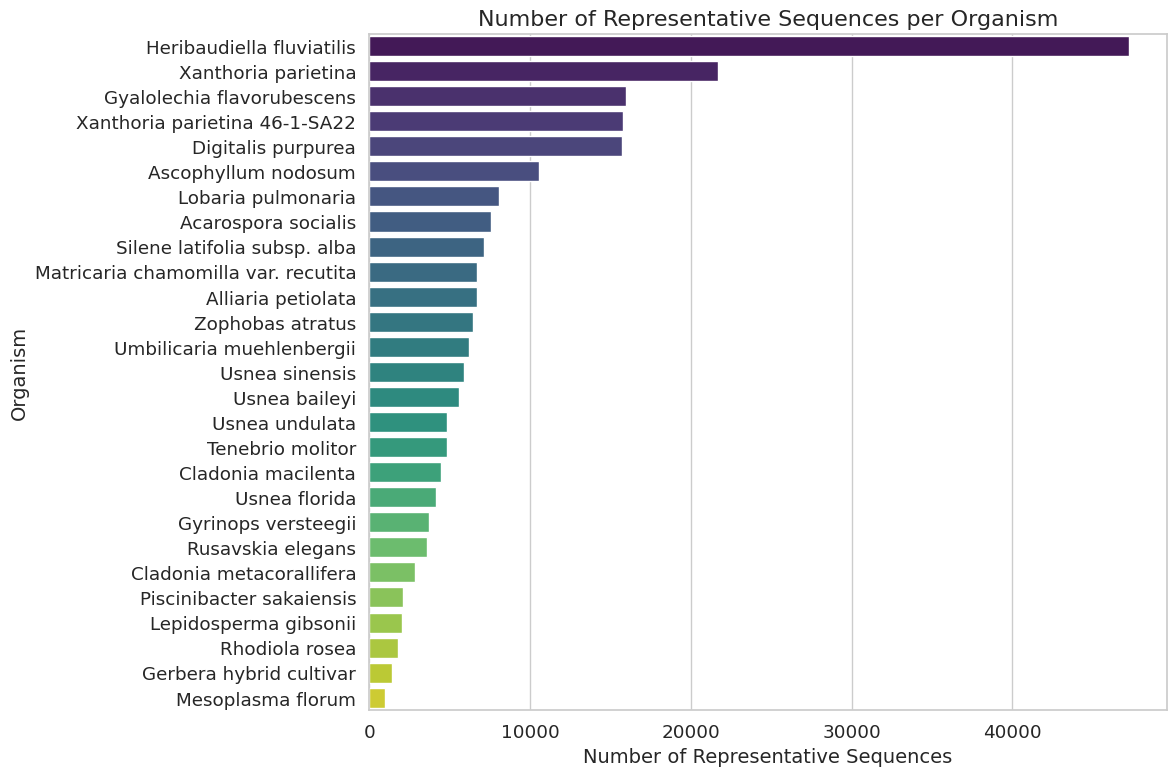

In [81]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Connect to the master DuckDB
# con = duckdb.connect("master.duckdb")

# Query: Count representative sequences per organism
query = """
    SELECT m.organism, COUNT(*) AS rep_count
    FROM sequences s
    JOIN sra_metadata m ON s.sample_id = m.sample_id
    WHERE s.is_representative = TRUE
    GROUP BY m.organism
    ORDER BY rep_count DESC
"""
with duckdb.connect(master_db_path) as con:
    df = con.execute(query).fetchdf()

# Optional: Inspect the resulting DataFrame
print(df)

# Use Seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Create a horizontal bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="rep_count", y="organism", data=df, palette="viridis")

# Set labels and title
ax.set_xlabel("Number of Representative Sequences", fontsize=14)
ax.set_ylabel("Organism", fontsize=14)
ax.set_title("Number of Representative Sequences per Organism", fontsize=16)

# Adjust layout for readability
plt.tight_layout()
plt.show()


<Figure size 1200x800 with 0 Axes>

Text(0.5, 0, 'Number of Sequences')

Text(0, 0.5, 'Organism')

Text(0.5, 1.0, 'Sequences per Organism: Total vs. Representatives (Sorted by rep count)')

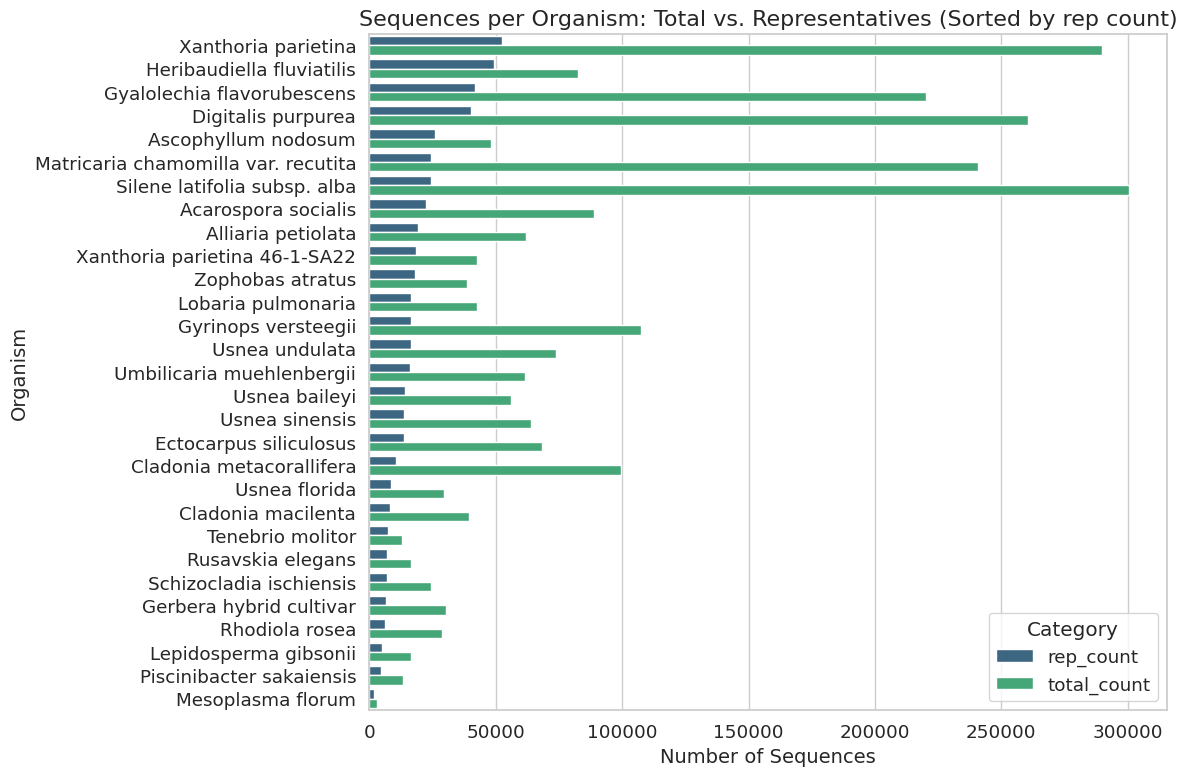

In [108]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

master_db_path = '/mnt/data3/planter_outputs/master.duckdb'
# # Query: Count total sequences and representative sequences per organism
query = """
    SELECT 
        m.organism, 
        COUNT(*) AS total_count,
        COUNT(CASE WHEN s.is_representative THEN 1 END) AS rep_count
    FROM sequences s
    JOIN sra_metadata m ON s.sample_id = m.sample_id
    GROUP BY m.organism
    ORDER BY rep_count DESC
"""

with duckdb.connect(master_db_path) as con:
    df = con.execute(query).fetchdf()

# Sort the DataFrame by representative count (it should already be sorted by the query, but just to be safe)
df = df.sort_values("rep_count", ascending=False)

# Create an order list for the organisms based on rep_count
organism_order = df["organism"].tolist()

# Melt the DataFrame into long format so that each organism has two rows: one for rep_count and one for total_count.
df_long = pd.melt(df, id_vars=["organism"], value_vars=["rep_count", "total_count"], 
                  var_name="Category", value_name="Count")

# Use Seaborn style for aesthetics.
sns.set(style="whitegrid", font_scale=1.2)

# Create a horizontal grouped bar plot.
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=df_long, x="Count", y="organism", hue="Category", 
                 palette="viridis", order=organism_order)

# Set labels and title.
ax.set_xlabel("Number of Sequences", fontsize=14)
ax.set_ylabel("Organism", fontsize=14)
ax.set_title("Sequences per Organism: Total vs. Representatives (Sorted by rep count)", fontsize=16)

# Adjust layout and legend.
plt.legend(title="Category", loc='lower right')
plt.tight_layout()
plt.show()


# Number of representative sequences that are annotated

<Figure size 1200x800 with 0 Axes>

/tmp/ipykernel_1972140/1106793953.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="annotated_count", y="organism", data=df, palette="viridis")


Text(0.5, 0, 'Number of Annotated Proteins')

Text(0, 0.5, 'Organism')

Text(0.5, 1.0, 'Annotated Proteins per Organism')

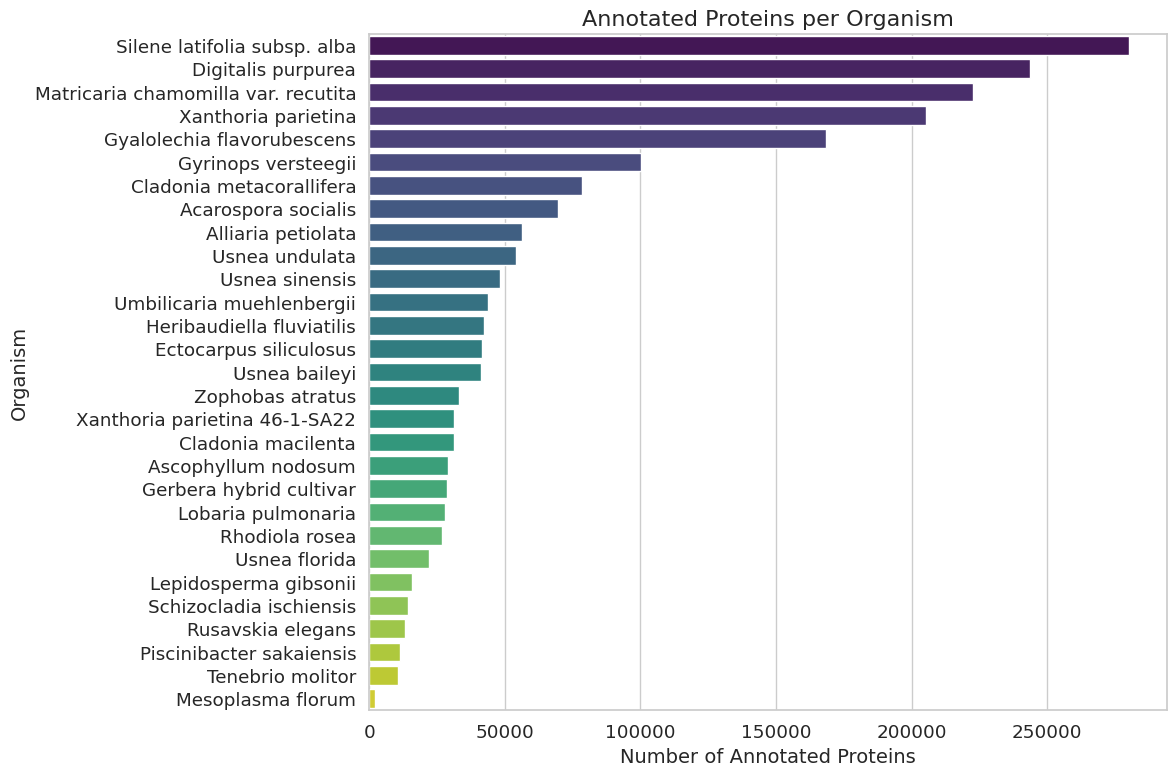

In [ ]:
# Query: Count representative sequences per organism
query = """
    SELECT m.organism, COUNT(a.seqhash_id) AS annotated_count
    FROM sequences s
    JOIN sra_metadata m ON s.sample_id = m.sample_id
    LEFT JOIN annotations a ON s.seqhash_id = a.seqhash_id
    WHERE a.seqhash_id IS NOT NULL
    GROUP BY m.organism
    ORDER BY annotated_count DESC
"""
with duckdb.connect(master_db_path) as con:
    df = con.execute(query).fetchdf()

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="annotated_count", y="organism", data=df, palette="viridis")
ax.set_xlabel("Number of Annotated Proteins", fontsize=14)
ax.set_ylabel("Organism", fontsize=14)
ax.set_title("Annotated Proteins per Organism", fontsize=16)
plt.tight_layout()
plt.show()


# Distribution of Sequence Lengths

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='length', ylabel='Count'>

Text(0.5, 0, 'Sequence Length (aa)')

Text(0, 0.5, 'Number of Sequences')

Text(0.5, 1.0, 'Distribution of Protein Sequence Lengths')

Text(0.95, 0.95, '\nn = 2,369,894\nmin = 100 aa\nmax = 7993 aa\nmean = 346.0 aa\nmedian = 266.0 aa\n')

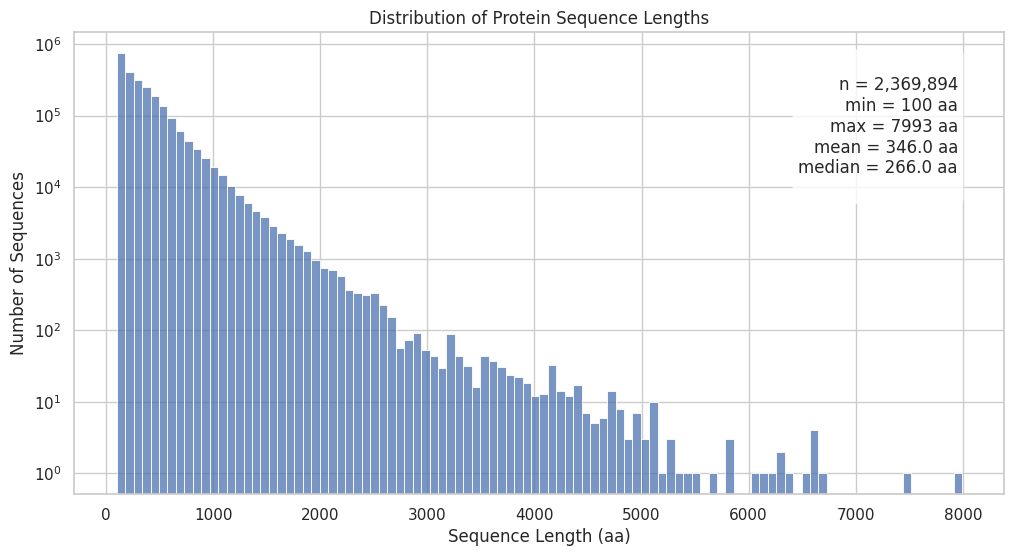

In [52]:
# %% [markdown]
# # Distribution of Sequence Lengths (DuckDB)
# 
# This notebook demonstrates how to:
# 
# 1. Connect to a DuckDB database
# 2. Query the sequence length distribution
# 3. Plot the distribution using a histogram

# %% [code]
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use Seaborn's style for enhanced visualization aesthetics
sns.set(style="whitegrid")

# Connect to the DuckDB database
db_path = '/mnt/data3/master-database.duckdb'
conn = duckdb.connect(db_path)

# Define and execute the SQL query to get sequence length distribution
query = """
SELECT length, COUNT(*) as count
FROM sequences
GROUP BY length
ORDER BY length;
"""
df_lengths = conn.execute(query).fetchdf()

# Create the plot
plt.figure(figsize=(12, 6))
sns.histplot(data=df_lengths, x='length', weights='count', bins=100)
plt.xlabel('Sequence Length (aa)')
plt.ylabel('Number of Sequences')
plt.title('Distribution of Protein Sequence Lengths')

# Add log scale for y-axis since counts can vary widely
plt.yscale('log')

# Add some basic statistics as text
stats_query = """
SELECT 
    COUNT(*) as total_sequences,
    MIN(length) as min_length,
    MAX(length) as max_length,
    AVG(length) as avg_length,
    MEDIAN(length) as median_length
FROM sequences;
"""
stats = conn.execute(stats_query).fetchone()

stats_text = f"""
n = {stats[0]:,}
min = {stats[1]} aa
max = {stats[2]} aa
mean = {stats[3]:.1f} aa
median = {stats[4]} aa
"""

plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

# Cleanup
conn.close()

## What's that ~8k sequence??

In [61]:
# Find details of the longest sequence(s)
with duckdb.connect(master_db_path) as con:
    query = """
    SELECT 
        s.seqhash_id,
        s.sequence,
        s.length,
        m.organism,
        m.sample_id
    FROM sequences s
    JOIN sra_metadata m ON s.sample_id = m.sample_id
    WHERE s.length = (SELECT MAX(length) FROM sequences)
    """
    display(con.execute(query).fetchdf())
    sequence = con.execute(query).fetchdf()['sequence'][0]
sequence

,seqhash_id,sequence,length,organism,sample_id
0,v1_DLS_60e876f877d0d7a46775d265adc8e993727f9a7...,MSSSHHLPTVSSQSIYEIQLSLVNRDQASSKKPKQAIMSHTEATSC...,7993,Usnea florida,SRR5489198


'MSSSHHLPTVSSQSIYEIQLSLVNRDQASSKKPKQAIMSHTEATSCTLPLLDGEDISNPHLISTEIQLEVVEKFPSFGKSSASPFNDMLCTAWGLLLRCYTGQDDVSFHFRHGNLEELRSNPAAPSDHFSTFRLVFVEEDTLLQCIRKAQDCYADDARGSQPLVSARSESSSPQYRNSFVWVQDALQEDTQDTLIQKGDVWLLAACSEGKLNLRLTSHSCDLSTSYMDILASTLDKVLKYILSSPNTQLVDLDYVSERHRGLIDLWSQDPHKLSSKCVHDLIHEQVLQRPDHEAVCAWDGSLTYHDLWVHVERIAQALSNMGVGPEVIVPLCFEKSMWTTVAILAVLKAGAGFCLLDATQPISRLQSLTRKLASNTLLCSRTHYQVLSSLVKNVVLIDAEALRNFPEGSSDPRTRASSSSNIVYVVFTSGSTGEPKAIVIEHGAYCSAFEAQKSGLCMESGLRALQYASYVFDASIQETLNPLMLGGTVCIPSEKSRINDLAATINDMRVDWAVLTPSVANFFTPSAVPRLKTLLLVGEAMSRENFATWSSIKLLNGYGPAECCVAAVANSDLSVNKDITQIGRGIGVRCWLVDPQDHNRLLPPGCVAELLIEGPTLARGYLNDLQRTRDSFIENPAWAAIEAAEYSTIRRMYKTGDLVRYNTSNGMLHFVGRKDNQVKLHGQRIELGEIEYHLANEPSVQQSVVLVPKAGFCRNRLVAVICLHPRTSASSEMGALRFVDEVEQEEAQPTIATARERLSHRLPTFMIPSIWLVVRSIPLLKSAKLDRKTVLSQVQGMSEETYTQWVQGREKDENPTTELEARLRSVWGDVLNLQAKQVGLNQSFLSLGGDSISAMMVQSRCKKNKIGVTVQDILRAKSLRHLATLAGAIGQSVKEVEVIEEDFDLSPIQSLYFQFPDRKGHFNQSVFVRLTKVFQPGALQQTAKAIVHRHSMLRARFRLSAFDDEWKQRITTDVTGSYTFRVHQCSSREEAEPLMFRTQ

In [111]:
# Find details of the longest sequence(s) and their annotations
with duckdb.connect(master_db_path) as con:
    query = """
    SELECT 
        s.seqhash_id,
        s.length,
        s.is_representative,
        m.organism,
        m.sample_id,
        a.description,
        a.preferred_name,
        a.seed_ortholog,
        a.evalue,
        a.score,
        a.eggnog_ogs,
        a.max_annot_lvl,
        a.cog_category
    FROM sequences s
    JOIN sra_metadata m ON s.sample_id = m.sample_id
    LEFT JOIN annotations a ON s.seqhash_id = a.seqhash_id
    WHERE s.length = (SELECT MAX(length) FROM sequences)
    """
    display(con.execute(query).fetchdf())

,seqhash_id,length,is_representative,organism,sample_id,description,preferred_name,seed_ortholog,evalue,score,eggnog_ogs,max_annot_lvl,cog_category
0,v1_DLS_60e876f877d0d7a46775d265adc8e993727f9a7...,7993,True,Usnea florida,SRR5489198,Phosphopantetheine attachment site,-,364733.XP_007786058.1,0.0,7287.0,"COG1020@1|root,KOG1178@2759|Eukaryota,38HAR@33...",4751|Fungi,Q


## BLASTing it manually

tblastn gave 

```
Bacidia gigantensis NRPS (KY384_005632), partial mRNA	Bacidia gigantensis	8882	8882	99%	0.0	54.26%	23859	XM_044814131.1
```

Phosphopantetheine is the penultimate step for the biosynthesis of acyl-CoAs

# The clustering finished.

In [ ]:
newClusterDB = pd.read_csv('/mnt/data3/planter_outputs/2-12-clustering/peps/cluster_94/newClusterDB.tsv', delimiter='\t', header=None, names=['repseq_id', 'seqhash_id'])
newClusterDB.shape

(257528, 2)

In [70]:
newClusterDB.groupby('repseq_id').size().sort_values(ascending=False)

repseq_id
v1_DLS_9839fd37cab91a5a5c5ecb4025a1a05e0c9c4fa6a1025d5d3d791fc0544f6249.p1    33
v1_DLS_bcc7d7fbb2299e94f1a504944dd66c7cbe58760c082cd70ed04e738f2b6fd33a.p1    29
v1_DLS_a4e1a9bd8e5543c74da6f3813e6abe2ec37dd735f1e58e79157eee0d125a0d69.p1    28
v1_DLS_80d29012b29140da47afde36e63d35b2669bda133a029af3a73b87a0f06a7574.p1    27
v1_DLS_90de4e0fabf939327bd48cc0b2165c1a47c975aef9d35424d7804cc75170597c.p1    25
                                                                              ..
v1_DLS_5b0191afb8b42c041a9228a1187a6bc68436812e5c966451bd6e56a724906d68.p1     1
v1_DLS_5b020373a8cf76e57b2f43a9ec6ff22482a1ea4465f85e2cdbb90347141143f3.p1     1
v1_DLS_5b03523dc5d29ef0fca06cd03264f4793411b9181a80f0f953e28d5bd0eca9c7.p1     1
v1_DLS_5b037b8222ac546a8b930696c2dfd99cef91a648c339b0afb5afcff96e4e785c.p1     1
v1_DLS_5aff4cfa7b227edf0b982677c95f78aa6b5cfcdca5822fbf6c6ace6d2fdace7c.p1     1
Length: 223851, dtype: int64

In [ ]:
# Get all repseq seqids and their sequences
def make_repseq_fasta(db_path, out_path):
    query = """
    SELECT s.seqhash_id, s.sequence
    FROM sequences s
    WHERE s.is_representative = TRUE
    """
    with duckdb.connect(db_path) as con:
        df = con.execute(query).fetchdf()
    with open(out_path, 'w') as f:
        for seqid, seq in df.values:
            f.write(f">{seqid}\n{seq}\n")

make_repseq_fasta(master_db_path, '/tmp/repseq.faa')


So for the Snakemake update:

0. Get sample.duckdb
1. Fetch s3://recombia.planter/master.duckdb
2. Prepare the sequences
    - repseq.faa from master.duckdb
    - cat *.peps.faa > all_peps.faa for batch updating
3. Run mmseqs2 cluster update
4. Concat master.duckdb with sample.duckdb --> new-master.duckdb
5. Update the new-master.duckdb with the cluster mapping
6. Update s3://recombia.planter/master.duckdb with the new-master.duckdb

# Phaetoexplorer

In [15]:
PHAETOEXPLORER_SRA_IDS = ['ERR12954282', 'ERR12954283', 'ERR12954285', 'ERR12954288', 'ERR12954289', 'ERR12954290', 'ERR12954291', 'ERR12954292', 'ERR12954293', 'ERR12954295', 'ERR12954296', 'ERR12954297', 'ERR12954300', 'ERR12954304', 'ERR12954305', 'ERR12954306', 'ERR12954307', 'ERR12954308', 'ERR12954309', 'ERR12954310', 'ERR12954311', 'ERR12954312', 'ERR12954313', 'ERR12954314', 'ERR12954316', 'ERR12954317', 'ERR12954321', 'ERR12954322', 'ERR12954325', 'ERR12954326', 'ERR12954327', 'ERR12954328', 'ERR12954323', 'ERR13340219', 'ERR13103808', 'ERR13103810', 'ERR13103818', 'ERR13103823', 'ERR13103827', 'ERR13103828', 'ERR13103846', 'ERR13103864', 'ERR13103868', 'ERR13103870', 'ERR13103874', 'ERR13103875', 'ERR13103804', 'ERR13103816', 'ERR13103817', 'ERR13103834', 'ERR13103839', 'ERR13103853', 'ERR13103867', 'ERR13103877', 'ERR13103881', 'ERR13103801', 'ERR13103802', 'ERR13103803', 'ERR13103806', 'ERR13103812', 'ERR13103820', 'ERR13103821', 'ERR13103822', 'ERR13103830', 'ERR13103833', 'ERR13103836', 'ERR13103837', 'ERR13103840', 'ERR13103842', 'ERR13103845', 'ERR13103847', 'ERR13103848', 'ERR13103854', 'ERR13103857', 'ERR13103860', 'ERR13103863', 'ERR13103866', 'ERR13103871', 'ERR13103879', 'ERR13103880', 'ERR13103883', 'ERR13103797', 'ERR13103799', 'ERR13103805', 'ERR13103813', 'ERR13103819', 'ERR13103831', 'ERR13103832', 'ERR13103841', 'ERR13103844', 'ERR13103856', 'ERR13103865', 'ERR13103872', 'ERR13103876', 'ERR13103878', 'ERR13334378', 'ERR13334379', 'ERR13334380', 'ERR13334382', 'ERR13334383', 'ERR13334384', 'ERR13103815', 'ERR13103825', 'ERR13103852', 'ERR13103858', 'ERR13103859', 'ERR13103861', 'ERR13103873', 'ERR13103885', 'ERR13147079', 'ERR13147088', 'ERR13147093', 'ERR13147098', 'ERR13147103', 'ERR13147097', 'ERR13147101', 'ERR13147102', 'ERR13147080', 'ERR13147081', 'ERR13147082', 'ERR13103798', 'ERR13103800', 'ERR13103807', 'ERR13103809', 'ERR13103811', 'ERR13103814', 'ERR13103824', 'ERR13103826', 'ERR13103829', 'ERR13103835', 'ERR13103838', 'ERR13103843', 'ERR13103849', 'ERR13103850', 'ERR13103851', 'ERR13103855', 'ERR13103862', 'ERR13103869', 'ERR13103882', 'ERR13103884', 'ERR12954284', 'ERR12954286', 'ERR12954287', 'ERR12954294', 'ERR12954298', 'ERR12954299', 'ERR12954301', 'ERR12954302', 'ERR12954303', 'ERR12954315', 'ERR12954318', 'ERR12954319', 'ERR12954320', 'ERR12954324', 'ERR13147078', 'ERR13147084', 'ERR13147086', 'ERR13147087', 'ERR13147091', 'ERR13147100', 'ERR13147089', 'ERR13147092', 'ERR13147095', 'ERR13147096', 'ERR13147099', 'ERR13147083', 'ERR13147085', 'ERR13147090', 'ERR13147094']

In [ ]:
from planter.scripts.get_srr_metadata import get_sra_info
from time import sleep
phaetoexplorer_metadata = []
for sra_id in PHAETOEXPLORER_SRA_IDS:
    md = get_sra_info(sra_id)
    phaetoexplorer_metadata.append(md)
    sleep(2)

In [ ]:
pd.DataFrame([md['run'] for md in phaetoexplorer_metadata])['size'].astype(int).sum()

1130370087376

<Figure size 1200x800 with 0 Axes>

/tmp/ipykernel_1972140/171651904.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="annotated_count", y="organism", data=df, palette="viridis")


Text(0.5, 0, 'Number of Annotated Sequences')

Text(0, 0.5, 'Organism')

Text(0.5, 1.0, 'Annotated Sequences per Organism')

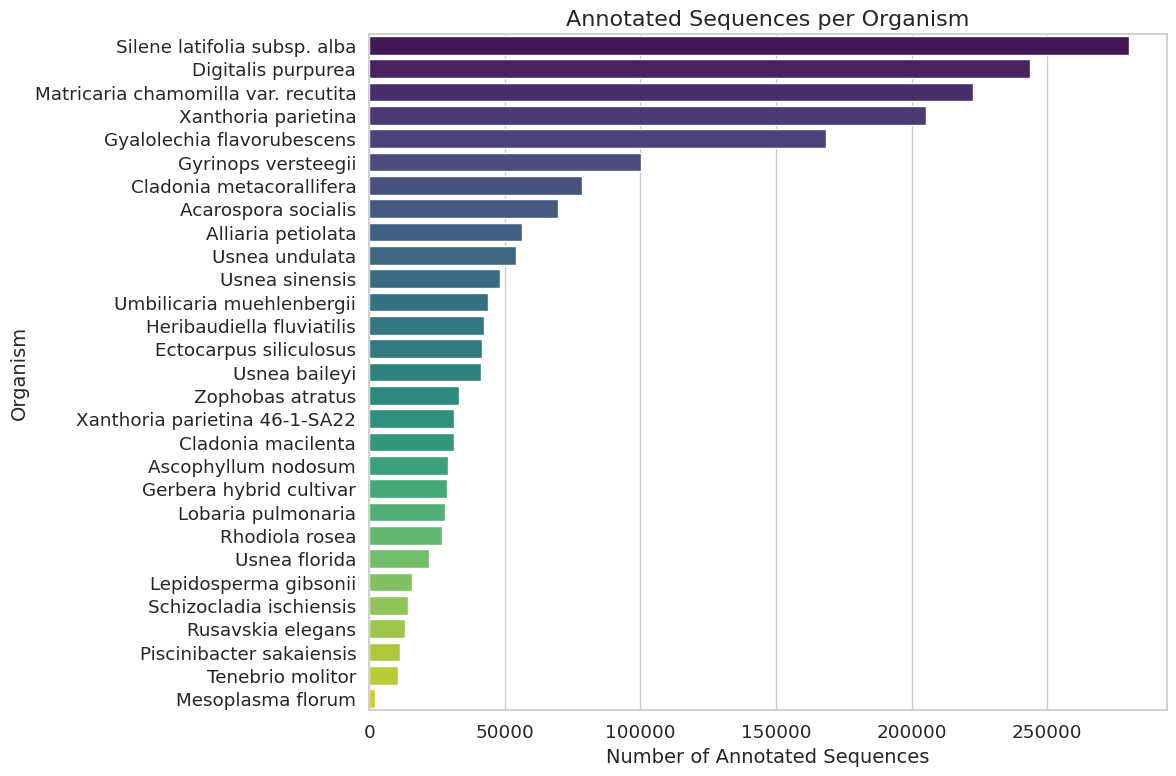

In [ ]:
master_db_path = '/mnt/data3/planter_outputs/master.duckdb'

# Query: Count representative sequences per organism
query = """
    SELECT m.organism, COUNT(a.seqhash_id) AS annotated_count
    FROM sequences s
    JOIN sra_metadata m ON s.sample_id = m.sample_id
    LEFT JOIN annotations a ON s.seqhash_id = a.seqhash_id
    WHERE a.seqhash_id IS NOT NULL
    GROUP BY m.organism
    ORDER BY annotated_count DESC
"""
with duckdb.connect(master_db_path) as con:
    df = con.execute(query).fetchdf()

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="annotated_count", y="organism", data=df, palette="viridis")
ax.set_xlabel("Number of Annotated Sequences", fontsize=14)
ax.set_ylabel("Organism", fontsize=14)
ax.set_title("Annotated Sequences per Organism", fontsize=16)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='length', ylabel='Count'>

Text(0.5, 0, 'Sequence Length (aa)')

Text(0, 0.5, 'Number of Sequences')

Text(0.5, 1.0, 'Distribution of Protein Sequence Lengths')

Text(0.95, 0.95, '\nn = 2,462,539\nmin = 100 aa\nmax = 7993 aa\nmean = 345.5 aa\nmedian = 265.0 aa\n')

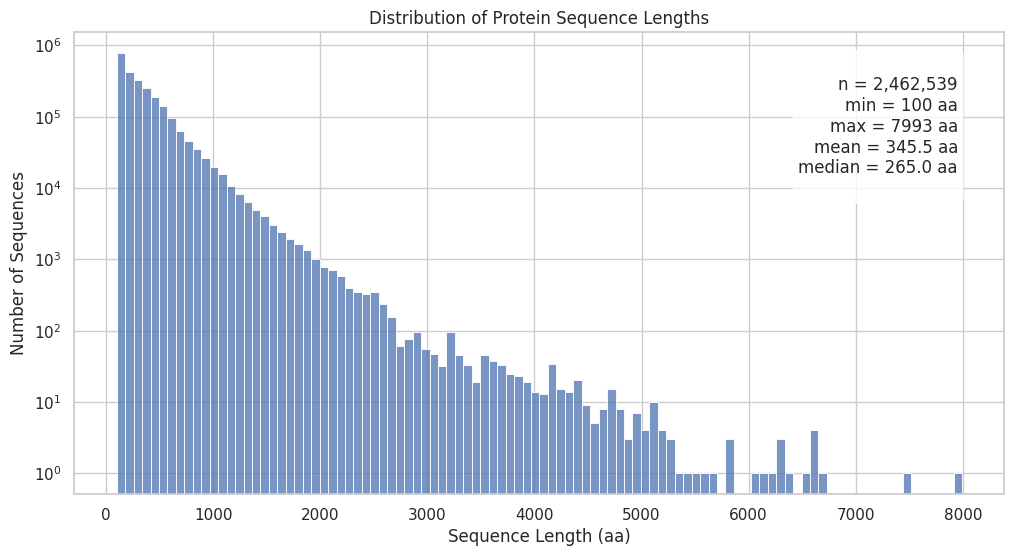

In [106]:
# %% [markdown]
# # Distribution of Sequence Lengths (DuckDB)
# 
# This notebook demonstrates how to:
# 
# 1. Connect to a DuckDB database
# 2. Query the sequence length distribution
# 3. Plot the distribution using a histogram

# %% [code]
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use Seaborn's style for enhanced visualization aesthetics
sns.set(style="whitegrid")

# Connect to the DuckDB database
db_path = '/mnt/data3/planter_outputs/master.duckdb'
conn = duckdb.connect(db_path)

# Define and execute the SQL query to get sequence length distribution
query = """
SELECT length, COUNT(*) as count
FROM sequences
GROUP BY length
ORDER BY length;
"""
df_lengths = conn.execute(query).fetchdf()

# Create the plot
plt.figure(figsize=(12, 6))
sns.histplot(data=df_lengths, x='length', weights='count', bins=100)
plt.xlabel('Sequence Length (aa)')
plt.ylabel('Number of Sequences')
plt.title('Distribution of Protein Sequence Lengths')

# Add log scale for y-axis since counts can vary widely
plt.yscale('log')

# Add some basic statistics as text
stats_query = """
SELECT 
    COUNT(*) as total_sequences,
    MIN(length) as min_length,
    MAX(length) as max_length,
    AVG(length) as avg_length,
    MEDIAN(length) as median_length
FROM sequences;
"""
stats = conn.execute(stats_query).fetchone()

stats_text = f"""
n = {stats[0]:,}
min = {stats[1]} aa
max = {stats[2]} aa
mean = {stats[3]:.1f} aa
median = {stats[4]} aa
"""

plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

# Cleanup
conn.close()